# Experiment Evaluation: Minimum Perimeter Polygons

Let us now consider the MP3. In previous work, the Delaunay Triangulation has already shown to be an excellent sparsification candidate. We now also consider other triangulations as well as some smaller experiments for the other techniques.

To save some time, we only consider one onion graph and one WSPD variant.

Experiments have been executed on AlgRys with 10min time limit.

In [1]:
import json
import os
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_theme()
plt.rcParams.update({'figure.max_open_warning': 0
                    ,"text.usetex": True
                    ,"font.family": "serif"
                    })
sns.set_palette("tab10")
PAPER_WIDTH = 10

## Explaining the data

In [2]:
t_experiments = pd.read_json("./00_mpp_data.json.zip")

In [3]:
t_experiments = pd.concat([t_experiments])

* **num_vertices:** The number of vertices in this instance. Most of the instances have been created in 5-steps.
* **sparsification_technique:** The used sparsification technique. The complete graph has "complete".
* **ObjVal:** The objective value of the solution (either optimal or the best at timeout).
* **filename_instance:** The file of the instance. Use this to distinguish different instances. The name also states something about its properties.
* **Runtime:** The runtime in seconds. The time limit has been 600s (10min).
* **Status:** The status code. 2 means solved to optimality. For sparisified instances, the instance may be solved in time but infeasible.
* **ObjBound:** The lower bound. If Status==2, it should equal the ObjVal.
* **solver:** Just the name of the solver. Not of relevance.
* **GRB_OUT_Time:** A list with the corresponding times the of the next two lists.
* **GRB_OUT_BestBd:** A list of the best bounds obtained over time (at the time of the previous list)
* **GRB_OUT_Incumbent:** A list of the best solutions (ObjVal) over time (analogous to previous list).

In [4]:
t_experiments

,num_vertices,sparsification_technique,ObjVal,filename_instance,Runtime,Status,ObjBound,solver,GRB_OUT_Time,GRB_OUT_BestBd,GRB_OUT_Incumbent
0,100,wspd2-3,21706.562446,kroB100_100_0.json,0.522996,2,2.170656e+04,Mpp,[0.0],[21190.9613],[21706.562446]
1,100,onion-1-1,31653.889544,kroB100_100_0.json,0.051153,2,3.165389e+04,Mpp,[0.0],[31386.2093],[31653.889544]
2,100,onion-0,27138.363470,kroB100_100_0.json,0.063678,2,2.713836e+04,Mpp,[0.0],[27085.3894],[27138.36347]
3,100,yao6-1,22914.444493,kroB100_100_0.json,0.022396,2,2.291444e+04,Mpp,[0.0],[22904.4093],[22914.444493]
4,100,greedyT,21631.459939,kroB100_100_0.json,0.080378,2,2.163146e+04,Mpp,[0.0],[21371.5918],[21631.459939]
...,...,...,...,...,...,...,...,...,...,...,...
125278,260,wspd2-0,NaN,20210530_uniform_real_260_3.json,0.003509,3,1.000000e+100,Mpp,None,None,None
125279,260,yao6-1,NaN,20210530_uniform_real_260_3.json,0.015023,3,1.000000e+100,Mpp,[],[],[]
125280,260,delaunayT,6028.943320,20210530_uniform_real_260_3.json,0.716249,2,6.028943e+03,Mpp,[0.0],[6027.64783],[6028.9433196]
125281,260,wspd2-3,5997.827652,20210530_uniform_real_260_3.json,8.286255,2,5.997828e+03,Mpp,"[7.0, 8.0]","[5990.99165, 5991.93513]","[6017.1900922, 5997.8276518]"


In [5]:
t_experiments["filename_instance"].unique().tolist()

['kroB100_100_0.json',
 'kroD100_100_0.json',
 'gr202_202_0.json',
 'ts225_225_0.json',
 'kroB200_200_0.json',
 'pr136_136_0.json',
 'eil101_101_0.json',
 'pr226_226_0.json',
 'rd400_400_0.json',
 'ulysses16_16_0.json',
 'ch150_150_0.json',
 'rd100_100_0.json',
 'kroA100_100_0.json',
 'pcb442_442_0.json',
 'ali535_535_0.json',
 'tsp225_225_0.json',
 'pr144_144_0.json',
 'pr439_439_0.json',
 'u574_574_0.json',
 'gr431_431_0.json',
 'att532_532_0.json',
 'fl417_417_0.json',
 'burma14_14_0.json',
 'att48_48_0.json',
 'bier127_127_0.json',
 'gr229_229_0.json',
 'eil76_76_0.json',
 'pr299_299_0.json',
 'lin105_105_0.json',
 'd198_198_0.json',
 'kroA200_200_0.json',
 'linhp318_318_0.json',
 'swiss42_42_0.json',
 'berlin52_52_0.json',
 'gil262_262_0.json',
 'ch130_130_0.json',
 'st70_70_0.json',
 'pr124_124_0.json',
 'pr152_152_0.json',
 'lin318_318_0.json',
 'gr137_137_0.json',
 'gr96_96_0.json',
 'a280_280_0.json',
 'pr76_76_0.json',
 'kroA150_150_0.json',
 'kroE100_100_0.json',
 'rat575_57

In [6]:
t_experiments["num_vertices"] = t_experiments["num_vertices"].apply(lambda x: round(x/10)*10)
t_experiments.sort_values(by=["sparsification_technique"], inplace=True)

In [7]:
# The WSPD instances are not competitive anyway, so we did not run them on all instances.
# The important triangulations were run on all instances.
t = t_experiments.groupby("sparsification_technique")[["filename_instance"]].nunique()
not_completely_run = t[t["filename_instance"] < t["filename_instance"].max()/2].index.tolist()
print(not_completely_run)
t

['onion-2-2', 'onion-2-3', 'wspd3-1', 'wspd3-3', 'wspd4-1', 'wspd4-3', 'wspd5-1', 'wspd5-3', 'wspd6-1', 'wspd6-3', 'wspd7-1', 'wspd7-3']


,filename_instance
sparsification_technique,
complete,6057
delaunayT,6057
greedyT,6057
mwT,6057
onion-0,6057
onion-1-1,6057
onion-1-2,3600
onion-1-3,3529
onion-2-1,6057


In [8]:
t_experiments = t_experiments[~t_experiments["sparsification_technique"].isin(not_completely_run)]

## 1. Feasibility

Do the sparsification techniques actually yield feasible instances?

For smaller instances, it can easily happen. So we only consider instances with at least 30 vertices.

The results are in line to the other problems. Allowing holes seems only to be a slight relaxation to hamilonicity.

In [9]:
only_larger_than = 30
only_smaller_than = 600
num_instances = t_experiments[(t_experiments["num_vertices"]>=only_larger_than) & (t_experiments["num_vertices"]<=only_smaller_than)]["filename_instance"].nunique()
print("num_instances", num_instances)
t = 1-(t_experiments[(t_experiments["Status"]!=3) & (t_experiments["num_vertices"]>=only_larger_than)& (t_experiments["num_vertices"]<=only_smaller_than)].groupby("sparsification_technique")["filename_instance"].nunique()/num_instances)
t

num_instances 5804


sparsification_technique
complete     0.000000
delaunayT    0.000000
greedyT      0.000000
mwT          0.000000
onion-0      0.000000
onion-1-1    0.002240
onion-1-2    0.405755
onion-1-3    0.417643
onion-2-1    0.002584
theta6-0     0.393694
theta6-1     0.403859
theta6-2     0.000000
wspd2-0      0.910062
wspd2-1      0.076671
wspd2-2      0.026017
wspd2-3      0.000000
yao6-0       0.336320
yao6-1       0.340283
yao6-2       0.000000
Name: filename_instance, dtype: float64

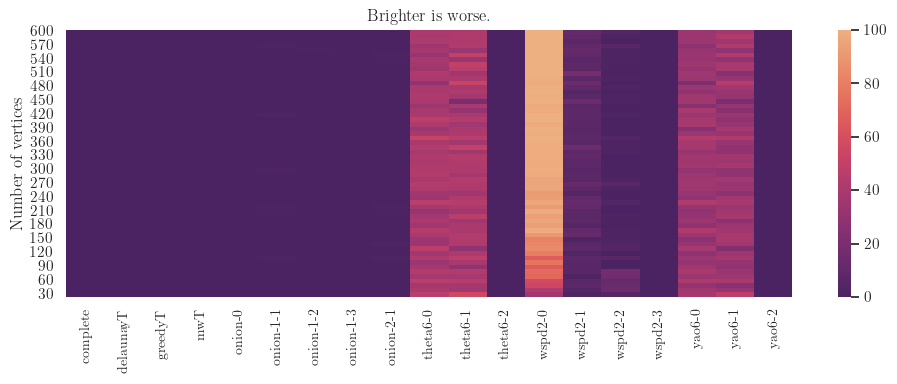

In [10]:
fig = plt.figure(figsize=(PAPER_WIDTH,4))
t = t_experiments[(t_experiments["num_vertices"]>=only_larger_than) & (t_experiments["num_vertices"]<=only_smaller_than)].copy()
t["Infeasible"] = (t["Status"]==3).apply(lambda x: 100 if x else 0)
t_ = t.groupby(["num_vertices", "sparsification_technique"])["Infeasible"].mean().reset_index()
t_
sparsification_techniques = t["sparsification_technique"].unique()
t__ = pd.DataFrame()
for s in sparsification_techniques:
    column = t_[t_["sparsification_technique"]==s].groupby("num_vertices")["Infeasible"].mean().copy()
    t__[s]=column
#pd.melt(t_,id_vars=["sparsification_technique"], value_vars=["timeout"])
t__.sort_index(inplace=True, ascending=False)
sns.heatmap(data=t__, cmap="flare_r", xticklabels=True, vmax=100)
plt.xlabel("")
plt.yticks(rotation=0)
#plt.gca().set_xticks(range(len(list(sparsification_techniques))))
plt.xticks(rotation=90,fontsize=10)
#plt.set_xticklabels(list(range(len(sparsification_techniques))))
plt.ylabel("Number of vertices")
plt.title("Brighter is worse.")
plt.tight_layout()
plt.savefig("./output/feasibility.pdf")
plt.show()

As we see above, the infeasible instances are relatively independent of the size.

Let us ignore the following sparsification techniques, because more than 10% of them are infeasible (non-hamiltonian).

In [11]:
t = 1-(t_experiments[(t_experiments["Status"]!=3) & (t_experiments["num_vertices"]>=only_larger_than)& (t_experiments["num_vertices"]<=only_smaller_than)].groupby("sparsification_technique")["filename_instance"].nunique()/num_instances)
print(t)
techniques_to_ignore = list(t[t>0.05].index)
techniques_to_ignore

sparsification_technique
complete     0.000000
delaunayT    0.000000
greedyT      0.000000
mwT          0.000000
onion-0      0.000000
onion-1-1    0.002240
onion-1-2    0.405755
onion-1-3    0.417643
onion-2-1    0.002584
theta6-0     0.393694
theta6-1     0.403859
theta6-2     0.000000
wspd2-0      0.910062
wspd2-1      0.076671
wspd2-2      0.026017
wspd2-3      0.000000
yao6-0       0.336320
yao6-1       0.340283
yao6-2       0.000000
Name: filename_instance, dtype: float64


['onion-1-2',
 'onion-1-3',
 'theta6-0',
 'theta6-1',
 'wspd2-0',
 'wspd2-1',
 'yao6-0',
 'yao6-1']

In [12]:
t_experiments_feasible = t_experiments[~t_experiments["sparsification_technique"].isin(techniques_to_ignore)]

In [13]:
# The WSPD instances are not competitive anyway, so we did not run them on all instances.
# The important triangulations were run on all instances.
t_experiments.groupby("sparsification_technique")[["filename_instance"]].nunique()

,filename_instance
sparsification_technique,
complete,6057
delaunayT,6057
greedyT,6057
mwT,6057
onion-0,6057
onion-1-1,6057
onion-1-2,3600
onion-1-3,3529
onion-2-1,6057


## 2. Solution Quality

Let us next look at the solution quality because bad solutions are not useful independent of how quick we can obtain them.

We are using *best upper bound/best lower bound* as metric (all bounds computed with timeout). We could compute optimal solutions for nearly all instances. For 600 vertices, the results are very near by.

In [14]:
t = t_experiments_feasible.copy()
t = t[t["Status"]!=3]
lbs = t_experiments[t_experiments["sparsification_technique"]=="complete"].groupby("filename_instance")["ObjBound"].max()
t = pd.merge(left=t, right=lbs, left_on="filename_instance", right_index=True, suffixes=("", "_best"))
t["Gap"] = t["ObjVal"]/t["ObjBound_best"]

Check for inconsistencies. The following table should be empty.

In [15]:
t[t["Gap"]<=0.999]

,num_vertices,sparsification_technique,ObjVal,filename_instance,Runtime,Status,ObjBound,solver,GRB_OUT_Time,GRB_OUT_BestBd,GRB_OUT_Incumbent,ObjBound_best,Gap


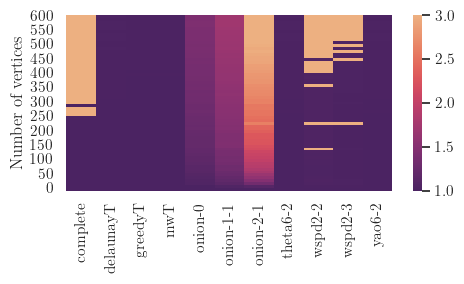

In [16]:
fig = plt.figure(figsize=(0.5*PAPER_WIDTH,3))
t_ = t.groupby(["num_vertices", "sparsification_technique"])["Gap"].mean().reset_index()
t_
sparsification_techniques = sorted(t["sparsification_technique"].unique())
t__ = pd.DataFrame()
for s in sparsification_techniques:
    if s=="complete-js":
        continue
    column = t_[t_["sparsification_technique"]==s].groupby("num_vertices")["Gap"].mean().copy()
    t__[s]=column.clip(upper=3)
#pd.melt(t_,id_vars=["sparsification_technique"], value_vars=["timeout"])
t__.sort_index(inplace=True, ascending=False)
sns.heatmap(data=t__, cmap="flare_r", xticklabels=True)
#plt.xlabel("Sparsification Technique")
plt.xlabel("")
plt.yticks(rotation=0)
#plt.gca().set_xticks(range(len(list(sparsification_techniques))))
plt.xticks(rotation=90)
#plt.set_xticklabels(list(range(len(sparsification_techniques))))
plt.ylabel("Number of vertices")
#plt.title("Brighter is worse.")
plt.tight_layout()
plt.savefig("./output/solution_quality_heatmap.pdf")
plt.show()

In [17]:
t.groupby(["sparsification_technique"])["Gap"].mean()

sparsification_technique
complete     2.663614e+96
delaunayT    1.008597e+00
greedyT      1.006382e+00
mwT          1.006244e+00
onion-0      1.280042e+00
onion-1-1    1.504071e+00
onion-2-1    2.481297e+00
theta6-2     1.009182e+00
wspd2-2      4.436380e+95
wspd2-3      8.154345e+93
yao6-2       1.008797e+00
Name: Gap, dtype: float64

In [18]:
t[t["num_vertices"].apply(lambda x: 150<=x<=250)].groupby(["sparsification_technique"])["Gap"].mean()

sparsification_technique
complete     1.000017e+00
delaunayT    1.005297e+00
greedyT      1.003547e+00
mwT          1.003403e+00
onion-0      1.243612e+00
onion-1-1    1.465655e+00
onion-2-1    2.358511e+00
theta6-2     1.005733e+00
wspd2-2      1.222197e+92
wspd2-3      1.209562e+92
yao6-2       1.005369e+00
Name: Gap, dtype: float64

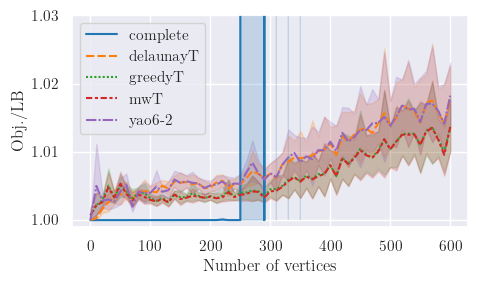

In [19]:
fig = plt.figure(figsize=(0.5*PAPER_WIDTH,3))
detail_sparsification_techniques = ["complete", "delaunayT", "greedyT", "mwT", "yao6-2"]
t_ = t[t["sparsification_technique"].isin(detail_sparsification_techniques)]
sns.lineplot(data=t_, x="num_vertices", y="Gap", hue="sparsification_technique", style="sparsification_technique")
plt.legend(title="")
plt.ylim(0.999, 1.03)
plt.xlabel("Number of vertices")
#plt.title("Lower is better.")
plt.tight_layout()
plt.ylabel("Obj./LB")
plt.savefig("./output/solution_quality_lineplot.pdf")
plt.show()

Greedy Triangulation and MWT yield results that are relatively stable below 0.5% of the optimum. Delaunay Triangulation and Yao Graphs are only slightly worse but seem to worsen (faster) with the instance size.

## 3. Runtime

Let us next take a look on the runtime. We are comparing a lot of different strategies which are too much for a lineplot. Instead we do a heatmap that shows us, which instances could still be solved wihtin a strict time limit. Infeasible instances are considered as unsolved (they are slightly worse but in both cases we do not obtain the desired solution from the sparsification).

From this heatmap, we select a few intersting strategies for which we then also compare the concrete runtime in a lineplot.

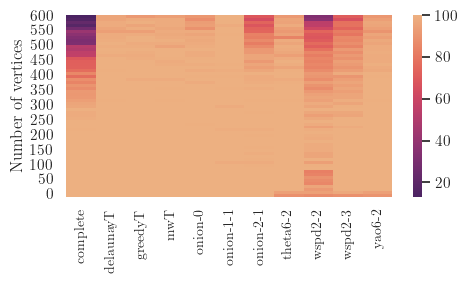

In [20]:
TIMEOUT_AFTER_S = 600
fig = plt.figure(figsize=(0.5*PAPER_WIDTH,3))

t = t_experiments_feasible.copy()
t["timeout"] = (t["Runtime"]>TIMEOUT_AFTER_S).apply(lambda x: 0 if x else 100)
t.loc[t["Status"]!=2, "timeout"]=0
t_ = t.groupby(["num_vertices", "sparsification_technique"])["timeout"].mean().reset_index()
t_
sparsification_techniques = t["sparsification_technique"].unique()
t__ = pd.DataFrame()
for s in sparsification_techniques:
    if s=="complete-js":
        continue
    column = t_[t_["sparsification_technique"]==s].groupby("num_vertices")["timeout"].mean().copy()
    t__[s]=column
#pd.melt(t_,id_vars=["sparsification_technique"], value_vars=["timeout"])
t__.sort_index(inplace=True, ascending=False)
sns.heatmap(data=t__, cmap="flare_r", xticklabels=True)
#plt.xlabel("Sparsification Technique")
plt.xlabel("")
plt.yticks(rotation=0)
#plt.gca().set_xticks(range(len(list(sparsification_techniques))))
plt.xticks(rotation=90,fontsize=10)
#plt.set_xticklabels(list(range(len(sparsification_techniques))))
plt.ylabel("Number of vertices")
#plt.title(f"Solved within {TIMEOUT_AFTER_S}s. Brighter is better.")
plt.tight_layout()
plt.savefig("./output/runtime_heatmap.pdf")
plt.show()

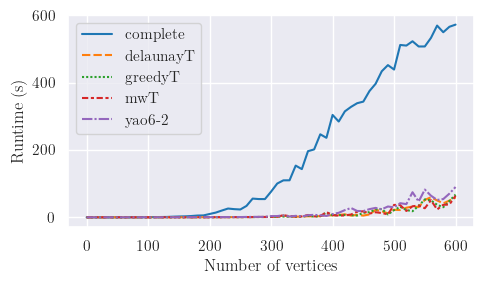

In [21]:
INTERESTING_STRATEGIES = ["complete", "delaunayT", "greedyT", "mwT", "yao6-2"]
fig = plt.figure(figsize=(0.5*PAPER_WIDTH,3))
t_ = t[t["sparsification_technique"].isin(INTERESTING_STRATEGIES)]
sns.lineplot(data=t_, x="num_vertices", y="Runtime", hue="sparsification_technique", style="sparsification_technique",errorbar=None)
plt.legend(title="")
plt.xlabel("Number of vertices")
plt.ylabel("Runtime (s)")
plt.tight_layout()
plt.savefig("./output/runtime_lineplot.pdf")
plt.show()

In [22]:
fig = plt.figure(figsize=(0.7*PAPER_WIDTH,4))

t = t_experiments_feasible.copy()
t["timeout"] = (t["Runtime"]>TIMEOUT_AFTER_S).apply(lambda x: 0 if x else 1)
t.loc[t["Status"]!=2, "Runtime"]=3600
t_ = t.groupby(["sparsification_technique"])["Runtime"].mean().reset_index()
t_


,sparsification_technique,Runtime
0,complete,750.711686
1,delaunayT,24.430354
2,greedyT,23.154128
3,mwT,27.800557
4,onion-0,68.760446
5,onion-1-1,10.135200
6,onion-2-1,198.327822
7,theta6-2,58.224821
8,wspd2-2,509.107502
9,wspd2-3,254.129024


<Figure size 700x400 with 0 Axes>

All sparsification techniques are notably faster than the complete graph. However, the difference is not as strong as for the other problems. There is no clear winner. All sparsification techniques are within the same order.

## Quality/Time Ration

Let us compare the quality per time ratio.

No clear advantage of any of the four best sparsification techniques can be seen. However, MWT and Greedy Triangulation reach slightly better solutions in the end as seen in the previous plots.

In [23]:

def get_data_for_obj_time(num_vertices):
    INTERESTING_STRATEGIES = ["complete", "delaunayT", "greedyT", "mwT", "yao6-2"]
    RANGE = list(range(0, 300))
    default_value = 10
    t = t_experiments_feasible.copy()
    t = t[t["num_vertices"]==num_vertices]
    t = t[t["sparsification_technique"].isin(INTERESTING_STRATEGIES)]
    if 3 in t["Status"].unique():
        print("WARNING: CONTAINS INFEASIBLE DATA")
    t = t[t["Status"]!=3]
    lbs = t_experiments[t_experiments["sparsification_technique"]=="complete"].groupby("filename_instance")["ObjBound"].max()
    t = pd.merge(left=t, right=lbs, left_on="filename_instance", right_index=True, suffixes=("", "_best"))
    def objective_at_time(row, time):
        times = row["GRB_OUT_Time"]
        if type(times) is not list:
            return float("inf")
        objectives = row["GRB_OUT_Incumbent"]
        return min((objectives[i] for i, time_ in enumerate(times) if time_<=time), default=float("inf"))
    relevant_times = RANGE
    data = {"strat": [], "gap": [], "time": [], "n": []}
    for i, row in t.iterrows():
        for t in relevant_times:
            data["strat"].append(row["sparsification_technique"])
            obj = objective_at_time(row, t)
            data["gap"].append(obj/row["ObjBound_best"] if obj<float("inf") else default_value)
            data["time"].append(t)
            data["n"].append(row["num_vertices"])
    return data

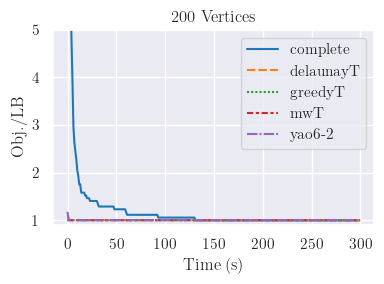

In [24]:
n = 200
t_ = pd.DataFrame(data=get_data_for_obj_time(n))
t_.sort_values(by="strat", inplace=True)
fig = plt.figure(figsize=(0.4*PAPER_WIDTH, 3))
sns.lineplot(data=t_, x="time", y="gap", hue="strat", style="strat", errorbar=None)
plt.ylim(0.9, 5)
plt.legend(title=None, loc="upper right")
plt.ylabel("Obj./LB")
plt.xlabel("Time (s)")
plt.title(f"{n} Vertices")
#plt.yticks([1, 3, 5, 7, 9])
plt.tight_layout()
plt.savefig(f"./output/gap_over_time_{n}.pdf")
plt.show()

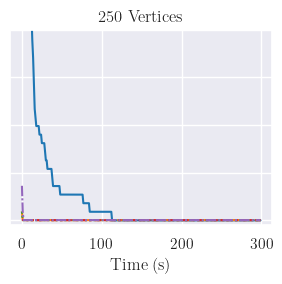

In [25]:
n= 250
t_ = pd.DataFrame(data=get_data_for_obj_time(n))
t_.sort_values(by="strat", inplace=True)
fig = plt.figure(figsize=(0.3*PAPER_WIDTH, 3))
sns.lineplot(data=t_, x="time", y="gap", hue="strat", style="strat", errorbar=None)
plt.ylim(0.9, 5)
plt.gca().get_legend().remove()
plt.ylabel("")
plt.xlabel("Time (s)")
plt.gca().set_yticklabels([])
plt.title(f"{n} Vertices")
#plt.yticks([1, 3, 5, 7, 9])
plt.tight_layout()
plt.savefig(f"./output/gap_over_time_{n}.pdf")
plt.show()

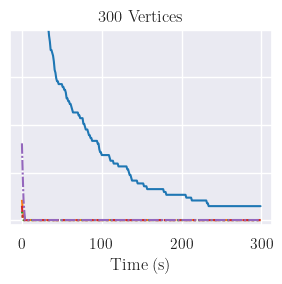

In [26]:
n = 300
t_ = pd.DataFrame(data=get_data_for_obj_time(n))
t_.sort_values(by="strat", inplace=True)
fig = plt.figure(figsize=(0.3*PAPER_WIDTH, 3))
sns.lineplot(data=t_, x="time", y="gap", hue="strat", style="strat", errorbar=None)
plt.ylim(0.9, 5)
plt.gca().get_legend().remove()
plt.ylabel("")
plt.xlabel("Time (s)")
plt.gca().set_yticklabels([])
plt.title(f"{n} Vertices")
#plt.yticks([1, 3, 5, 7, 9])
plt.tight_layout()
plt.savefig(f"./output/gap_over_time_{n}.pdf")
plt.show()